In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import gym
import scipy.signal

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
steps_per_epoch = 4000
epochs = 30
hidden_sizes = (64, 64)
train_iterations = 80
seed = 543
np.random.seed(seed=seed)

In [4]:
def discounted_cumulative_sums(x, discount):
    '''
    :param array(n) x: reward
    :param float discount
    '''
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [5]:
class Buffer:
    def __init__(self, observation_dimensions, size, gamma=0.99):
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.gamma = gamma
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward):
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.pointer += 1

    def finish_trajectory(self):
        path_slice = slice(self.trajectory_start_index, self.pointer)

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            self.reward_buffer[path_slice], self.gamma
        )
        self.trajectory_start_index = self.pointer

    def get(self):
        self.pointer, self.trajectory_start_index = 0, 0
        self.advantage_buffer -= np.mean(self.advantage_buffer)
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
        )

In [6]:
def mlp(x, sizes, activation='relu', output_activation=None):
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)

In [7]:
def logprobabilities(logits, a):
    '''
    :param array(n, num_actions) logits: model output
    :param array(n) a
    :return array(n) logprobability
    '''
    logprobabilities_all = tf.math.log(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability

In [8]:
@tf.function
def sample_action(observation):
    '''
    :param array(n, 4) observation
    :return array(1) action
    '''
    logits = model(observation)
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
    return action

In [10]:
env = gym.make("CartPole-v1")
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.n

buffer = Buffer(observation_dimensions, steps_per_epoch)

observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], 'relu', 'softmax')
model = keras.Model(inputs=observation_input, outputs=logits)
optimizer = keras.optimizers.Adam()

/content/drive/My Drive/Colab Notebooks/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/content/drive/My Drive/Colab Notebooks/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [11]:
def train_model(observation_buffer, action_buffer, advantage_buffer):
    '''
    :param array(n, observation_dimensions) observation_buffer
    :param array(n) action_buffer
    :param array(n) advantage_buffer
    '''
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(
            logprobabilities(model(observation_buffer), action_buffer) * advantage_buffer
        )
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [12]:
observation, episode_return = env.reset(), 0
mean_reward_multistep = np.zeros(epochs)

for epoch in range(epochs):
    sum_return = 0
    num_episodes = 0

    for t in range(steps_per_epoch):
        observation = observation.reshape(1, -1)
        action = sample_action(observation)
        observation_new, reward, done, _ = env.step(action[0].numpy())
        episode_return += reward

        buffer.store(observation, action, reward)

        observation = observation_new

        if done or (t == steps_per_epoch - 1):
            buffer.finish_trajectory()
            sum_return += episode_return
            num_episodes += 1
            observation, episode_return = env.reset(), 0
            # break

    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
    ) = buffer.get()

    for _ in range(train_iterations):
        train_model(observation_buffer, action_buffer, advantage_buffer)
    
    print(
        f" Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}"
    )
    mean_reward_multistep[epoch] = sum_return / num_episodes

 Epoch: 1. Mean Return: 23.668639053254438
 Epoch: 2. Mean Return: 55.55555555555556
 Epoch: 3. Mean Return: 9.433962264150944
 Epoch: 4. Mean Return: 9.345794392523365
 Epoch: 5. Mean Return: 9.36768149882904
 Epoch: 6. Mean Return: 9.345794392523365
 Epoch: 7. Mean Return: 9.345794392523365
 Epoch: 8. Mean Return: 9.345794392523365
 Epoch: 9. Mean Return: 9.389671361502348
 Epoch: 10. Mean Return: 9.411764705882353
 Epoch: 11. Mean Return: 9.324009324009324
 Epoch: 12. Mean Return: 9.389671361502348
 Epoch: 13. Mean Return: 9.389671361502348
 Epoch: 14. Mean Return: 9.433962264150944
 Epoch: 15. Mean Return: 9.324009324009324
 Epoch: 16. Mean Return: 9.345794392523365
 Epoch: 17. Mean Return: 9.25925925925926
 Epoch: 18. Mean Return: 9.411764705882353
 Epoch: 19. Mean Return: 9.389671361502348
 Epoch: 20. Mean Return: 9.389671361502348
 Epoch: 21. Mean Return: 9.30232558139535
 Epoch: 22. Mean Return: 9.36768149882904
 Epoch: 23. Mean Return: 9.324009324009324
 Epoch: 24. Mean Return

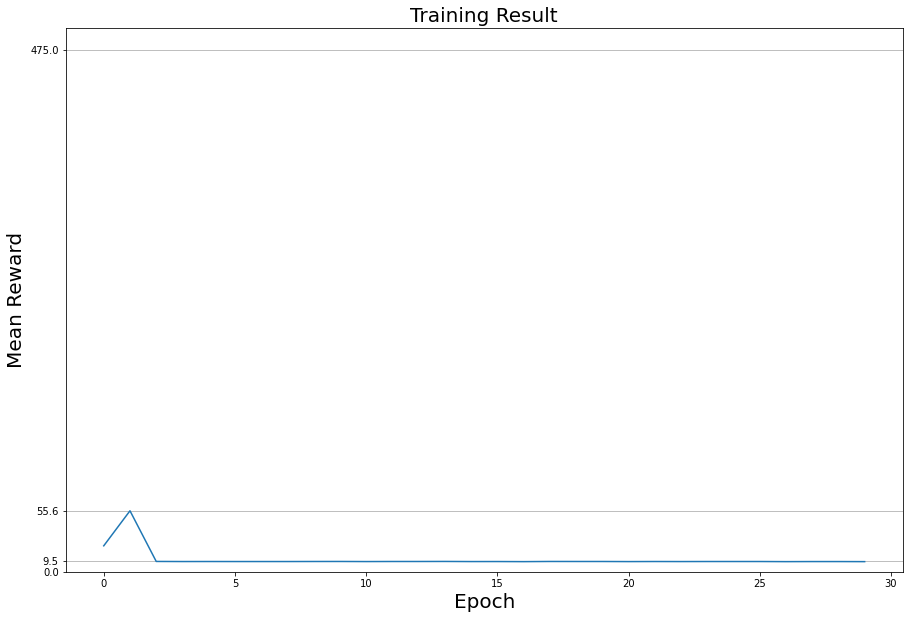

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, epochs), mean_reward_multistep)
plt.xlabel('Epoch', fontsize=20) 
plt.ylabel('Mean Reward', fontsize=20)
plt.title("Training Result", fontsize=20)
plt.ylim(0, env.spec.reward_threshold+20)
plt.yticks([0, 9.5, mean_reward_multistep.max(), env.spec.reward_threshold])
plt.grid(axis='y')
plt.show()

In [ ]:
from gym.wrappers import RecordVideo
record_env = RecordVideo(gym.make('CartPole-v1'), './video')

current_state = record_env.reset()
sum_reward = 0
while 1:
    action = sample_action(current_state.reshape(1, -1))
    next_state, reward, done, info = record_env.step(action[0].numpy())
    sum_reward += reward
    # current_state = next_state
    if done:
        break

record_env.close()
print(sum_reward)

/content/drive/My Drive/Colab Notebooks/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/content/drive/My Drive/Colab Notebooks/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/content/drive/My Drive/Colab Notebooks/

13.0
